In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Concatenate, concatenate, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.constraints import MaxNorm
#from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import time
import ast
from PIL import Image

In [31]:
FILE_PATH = path=r'/content/gdrive/MyDrive/Univ/ML project 2'
TRAIN_FEATURES_PATH = FILE_PATH + '/data/train/images'
TRAIN_LABELS_PATH = FILE_PATH + '/data/train/groundtruth'
TRAIN_SAMPLES = 100
TEST_FEATURES_PATH = FILE_PATH + '/data/test_set_images'
TEST_SAMPLES = 50
IMAGE_SIDE = 400
INPUT_SIDE = 128
VALIDATION_RATIO = 0.1
USE_SHUFFLE = True

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
def load_data():
    x_train = []
    y_train = []
    for i in range(TRAIN_SAMPLES):
        img_name = '/satImage_{:03}.png'.format(i+1)
        train_feature = plt.imread(TRAIN_FEATURES_PATH + img_name)
        train_label = plt.imread(TRAIN_LABELS_PATH + img_name)
        x_train.append(train_feature)
        y_train.append(train_label)
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    return x_train, y_train

def transform_labels(y_train):
    y_train = np.round(y_train)
    y_train = y_train[..., np.newaxis]
    return y_train

def train_test_split(x, y, validation_ratio=VALIDATION_RATIO, shuffle=USE_SHUFFLE):
    train_num = int(np.round(x.shape[0] * (1 - validation_ratio)))
    if shuffle:
        indexes = np.random.permutation(np.arange(x.shape[0]))
        x = x[indexes]
        y = y[indexes]
    x_test = x[train_num:,:,:,:]
    y_test = y[train_num:,...]
    x_train = x[:train_num,...]
    y_train = y[:train_num,...]
    return x_train, y_train, x_test, y_test

x_train, y_train = load_data()
y_train = transform_labels(y_train)
x_train, y_train, x_test, y_test = train_test_split(x_train, y_train)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(90, 400, 400, 3)
(90, 400, 400, 1)
(10, 400, 400, 3)
(10, 400, 400, 1)


In [ ]:
y = np.concatenate([y_train, y_test])
y.mean()

0.20046838

roads constitude 20% of images => road labels : non-road labels = 1 : 4 <br>
we will set weight parameter for road labels in weighted binary crossentropy equal to 4

In [6]:
#custom losses

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def weighted_binary_crossentropy(y_true, y_pred, weight=4):
    '''
    weight: int
        weight to be set to road labels while retaining 1 weight for non-road labels
    '''
    weights = y_true * (weight-1) + 1
    weighted_bce = K.binary_crossentropy(y_true, y_pred) * weights
    return K.mean(weighted_bce)

#custom metrics

def F1_score(y_true, y_pred, delta=1e-8):
    y_pred = K.round(y_pred)
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    precision = TP / (TP + FP + delta)
    recall = TP / (TP + FN + delta)
    f1_score = 2 * precision * recall / (precision + recall + delta) 
    return f1_score


In [19]:
class ModelWrapper():

    def __init__(self, model, params):
        '''

        Parameters
        ----------
        model : tf.keras.Model
        params : dict
            Must contain the following attributes:
                params['metrics_names']: list
                    names of metrics tracked by model
                params['input_side']: int
                    model's input must have (input_side, input_side, 3) shape
                params['image_side']: int
                    side of images to be received for training
                params['reg_name']: None or str from ['l1', 'l2']
                    name of regularizer. It is used only to track the regularization
                    penalty of the model
                params['lambd']: float
                    regularization parameter
                params['batch_size']: int
                params['batches_per_epoch']: int
                params['path']: string
                    It is used to save and download model's weights and
                    training characteristics from this path
                params['main_metric_fn']: function
                    metric for evaluating results on initial (not cropped) images. 
                    It is used to compare different models to save the best model's weights
        
        '''
        
        self.model = model
        self.metrics_names = params['metrics_names']
        self.input_side = params['input_side']
        self.image_side = params['image_side']
        self.reg_name = params['reg_name']
        self.lambd = params['lambd']
        self.batch_size = params['batch_size']
        self.batches_per_epoch = params['batches_per_epoch']
        self.path = params['path']
        self.main_metric_fn = params['main_metric_fn']
        self.main_metric_name = 'Full_img_' + self.main_metric_fn.__name__

        self.metrics_per_epoch = {}
        for metric in self.metrics_names:
            self.metrics_per_epoch[metric+'_train'] = []
        for metric in self.metrics_names:
            self.metrics_per_epoch[metric+'_test'] = []
        if self.reg_name != None:
            self.metrics_per_epoch['regularizer'] = []
        self.metrics_per_epoch[self.main_metric_name] = []

        self.epoch = 0
        self.best_main_metric_score = None
    

    def train(self, x_train, y_train, x_test, y_test, epochs, use_flip=True, use_rot90=True, rot_angle = None, shift=None, save_best=True):
        '''
        
        Parameters
        ----------
        use_flip: bool
            whether to use image flipping for training data augmentation
        
        use_rot90: bool
            whether to use image rotation by multiple of 90 degrees for 
            training data augmentation
        
        rot_angle: None or float
            If float, add random rotation from (-rot_angle, rot_angle) degrees to 
            training images
        
        shift : None or int
            when predictiong and evaluating model on initial images, smaller images 
            will be cropped from them with shifting size 'shift'. Smaller shift value 
            improves prediction results at the expence of more computational cost.
            If None, it is set to the biggest possible value (self.input_side) 

        '''
        
        if shift == None:
            shift = self.input_side
        
        x_test_cropped, y_test_cropped = self.transform_test_data(x_test, y_test, shift)
        
        for epoch in range(epochs):
            
            metrics_per_batch = {}
            for metric in self.metrics_names:
                metrics_per_batch[metric] = tf.keras.metrics.Mean()

            for _ in range(self.batches_per_epoch):
                x_batch, y_batch = self.get_batch(x_train, y_train, use_flip, use_rot90, rot_angle)
                res = self.model.train_on_batch(x_batch, y_batch)
                for i, metric in enumerate(self.metrics_names):
                    metrics_per_batch[metric](res[i])
            
            for metric in self.metrics_names:
                self.metrics_per_epoch[metric+'_train'].append(metrics_per_batch[metric].result().numpy())
                
            res = self.model.evaluate(x_test_cropped, y_test_cropped, verbose=0)
            for i, metric in enumerate(self.metrics_names):
                self.metrics_per_epoch[metric+'_test'].append(res[i])
            
            if self.reg_name != None:
                self.metrics_per_epoch['regularizer'].append(self.reg_score())
            
            self.metrics_per_epoch[self.main_metric_name].append(self.evaluate(x_test, y_test, shift))
            
            #if current weights are the best, save them
            if (self.best_main_metric_score == None) or (self.metrics_per_epoch[self.main_metric_name][-1] > self.best_main_metric_score):
                self.best_main_metric_score = self.metrics_per_epoch[self.main_metric_name][-1]
                if save_best:
                    self.save_model()
            
            self.epoch += 1
            self.print_state()
    
    
    def predict(self, images, shift=None):
        
        if shift == None:
            shift = self.input_side
        
        pred = np.zeros([images.shape[0], self.image_side, self.image_side, 1])
        #count number of predictions for each pixel
        counter = np.zeros([images.shape[0], self.image_side, self.image_side, 1])
        
        for x0 in range(0, self.image_side, shift):
            for y0 in range(0, self.image_side, shift):
                #prevent going out of borders
                x = min(x0, self.image_side - self.input_side)
                y = min(y0, self.image_side - self.input_side)
                pred[:, x:x+self.input_side, y:y+self.input_side, :] += self.model.predict(images[:, x:x+self.input_side, y:y+self.input_side, :])
                counter[:, x:x+self.input_side, y:y+self.input_side, :] += 1
        
        return pred / counter
    
    
    def evaluate(self, images, y_true, shift=None):
             
        y_pred = self.predict(images, shift)
        scores = map(lambda true_pred: self.main_metric_fn(true_pred[0], true_pred[1]), zip(y_true, y_pred))
        scores = np.array(list(scores))
        return scores.mean()
    
    
    def transform_test_data(self, x_test, y_test, shift):
        
        s = self.input_side
        S = self.image_side
        out_x_test = [x_test[k,x:x+s,y:y+s,:] for x in range(0,S-s+1,shift) for y in range(0,S-s+1,shift) for k in range(x_test.shape[0])]
        out_y_test = [y_test[k,x:x+s,y:y+s,:] for x in range(0,S-s+1,shift) for y in range(0,S-s+1,shift) for k in range(y_test.shape[0])]
        return np.array(out_x_test), np.array(out_y_test)
    
    
    def get_batch(self, x_train, y_train, use_flip=True, use_rot90=True, rot_angle = None):
        
        ids = np.random.randint(0, x_train.shape[0], self.batch_size)
        x_train_selected = x_train[ids]
        y_train_selected = y_train[ids]

        if rot_angle != None:
            angles = np.random.uniform(-rot_angle, rot_angle, self.batch_size)
            x_train_selected = np.array(list(map(lambda img_angle: self.rotate_image(img_angle[0], img_angle[1]), zip(x_train_selected, angles))))
            y_train_selected = np.array(list(map(lambda img_angle: self.rotate_image(img_angle[0][:,:,0], img_angle[1]), zip(y_train_selected, angles))))
            y_train_selected = y_train_selected[..., np.newaxis]

        left_bounds = np.random.randint(0, self.image_side - self.input_side + 1, self.batch_size)
        upper_bounds = np.random.randint(0, self.image_side - self.input_side + 1, self.batch_size)
        x_batch = [img[x:x+self.input_side, y:y+self.input_side, :] for img, x, y in zip(x_train_selected, left_bounds, upper_bounds)]
        y_batch = [img[x:x+self.input_side, y:y+self.input_side, :] for img, x, y in zip(y_train_selected, left_bounds, upper_bounds)]
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)
        
        if use_flip:
            axis_to_flip = np.random.randint(0, 3, x_batch.shape[0]) #if 0, no flipping applied
            for k in range(1,3):
                x_batch[axis_to_flip == k] = np.flip(x_batch[axis_to_flip == k], axis=k)
                y_batch[axis_to_flip == k] = np.flip(y_batch[axis_to_flip == k], axis=k)

        if use_rot90:
            #times to rotate by 90 degrees counterclockwise
            times_to_rotate = np.random.randint(0, 4, x_batch.shape[0])
            for k in range(1,4):
                x_batch[times_to_rotate == k] = np.rot90(x_batch[times_to_rotate == k], k=k, axes=(1,2))
                y_batch[times_to_rotate == k] = np.rot90(y_batch[times_to_rotate == k], k=k, axes=(1,2))
        
        return x_batch, y_batch
    
    
    def rotate_image(self, image, angle):
        img = Image.fromarray((image * 255).astype(np.uint8))
        img = img.rotate(angle)
        img = np.array(img) / 255.
        return img
    
    
    def print_state(self):
        print('Epoch: {:04d}: '.format(self.epoch), end='')
        for metric in self.metrics_per_epoch.keys():
            print('{}: {:.5f}, '.format(metric, self.metrics_per_epoch[metric][-1]), end='')
        print()
    
    
    def reg_score(self):
        
        if self.reg_name == None:
            return
        elif self.reg_name == 'l1':
            reg_fn = lambda x: np.sum(np.abs(x))
        elif self.reg_name == 'l2':
            reg_fn = lambda x: np.sum(np.square(x))
        else:
            raise Exception('Incorrect value of reg_name')
        
        res = 0.
        for layer in self.model.layers:
            if (layer.name.startswith('conv2d') or layer.name.startswith('conv2d_transpose')) and (not layer.name.endswith('last')):
                kernel_weights = layer.get_weights()[0]
                res += reg_fn(kernel_weights)
        return res * self.lambd
    

    def draw_metrics(self):
        
        fig, axes = plt.subplots(len(self.metrics_names), 2, sharex=True, figsize=(12, 6*len(self.metrics_names)))
        for i, metric in enumerate(self.metrics_names):

            axes[i,0].set_title('Train {} vs epochs'.format(metric))
            axes[i,0].set_xlabel("epochs", fontsize=14)
            axes[i,0].set_ylabel("loss", fontsize=14)
            axes[i,0].plot(self.metrics_per_epoch[metric+'_train'])

            axes[i,1].set_title('Test {} vs epochs'.format(metric))
            axes[i,1].set_xlabel("epochs", fontsize=14)
            axes[i,1].set_ylabel("loss", fontsize=14)
            axes[i,1].plot(self.metrics_per_epoch[metric+'_test'])
        
        plt.show()
    
    
    def save_model(self):

        #saving model's weights
        model_path = FILE_PATH + self.path + '/model'               
        self.model.save_weights(model_path)

        #saving history of model's metrics
        train_info_path = FILE_PATH + self.path + '/train_info.txt'
        f=open(train_info_path,'w')
        for metric in self.metrics_per_epoch.keys():
            f.write(str(self.metrics_per_epoch[metric]) + '\n')
        f.close()
    
    
    def load_model(self):

        #loading model's weights
        model_path = FILE_PATH + self.path + '/model'
        self.model.load_weights(model_path)

        #loading history of model's metrics
        train_info_path = FILE_PATH + self.path + '/train_info.txt'
        f = open(train_info_path,'r')
        train_info = f.read()
        train_info = train_info.split(sep='\n')
        for i, metric in enumerate(self.metrics_per_epoch.keys()):
            self.metrics_per_epoch[metric] = ast.literal_eval(train_info[i])
        f.close()
        self.epoch = len(self.metrics_per_epoch[self.main_metric_name])

In [20]:
def get_model(input_side=INPUT_SIDE, base_activation='elu', dropout_rate = 0.2):

    inputs = Input(shape=(INPUT_SIDE, INPUT_SIDE, 3))
    conv1 = Conv2D(16, (3,3), strides=(1,1), padding='same', activation=base_activation)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(dropout_rate)(conv1)
    conv1 = Conv2D(16, (3,3), strides=(1,1), padding='same', activation=base_activation)(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPool2D((2, 2), strides=(2,2))(conv1)
    
    conv2 = Conv2D(32, (3,3), strides=(1,1), padding='same', activation=base_activation)(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(dropout_rate)(conv2)
    conv2 = Conv2D(32, (3,3), strides=(1,1), padding='same', activation=base_activation)(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPool2D((2, 2), strides=(2,2))(conv2)
    
    conv3 = Conv2D(64, (3,3), strides=(1,1), padding='same', activation=base_activation)(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(dropout_rate)(conv3)
    conv3 = Conv2D(64, (3,3), strides=(1,1), padding='same', activation=base_activation)(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPool2D((2, 2), strides=(2,2))(conv3)
    
    conv4 = Conv2D(128, (3,3), strides=(1,1), padding='same', activation=base_activation)(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(dropout_rate)(conv4)
    conv4 = Conv2D(128, (3,3), strides=(1,1), padding='same', activation=base_activation)(conv4)
    conv4 = BatchNormalization()(conv4)
    
    upsample5 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='linear')(conv4)
    upsample5 = Concatenate(axis=-1)([upsample5, conv3])
    conv5 = Conv2D(64, (3,3), strides=(1,1), padding='same', activation=base_activation)(upsample5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Dropout(dropout_rate)(conv5)
    conv5 = Conv2D(64, (3,3), strides=(1,1), padding='same', activation=base_activation)(conv5)
    conv5 = BatchNormalization()(conv5)
    
    upsample6 = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='linear')(conv5)
    upsample6 = Concatenate(axis=-1)([upsample6, conv2])
    conv6 = Conv2D(32, (3,3), strides=(1,1), padding='same', activation=base_activation)(upsample6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(dropout_rate)(conv6)
    conv6 = Conv2D(32, (3,3), strides=(1,1), padding='same', activation=base_activation)(conv6)
    conv6 = BatchNormalization()(conv6)
    
    upsample7 = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same', activation='linear')(conv6)
    upsample7 = Concatenate(axis=-1)([upsample7, conv1])
    conv7 = Conv2D(16, (3,3), strides=(1,1), padding='same', activation=base_activation)(upsample7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(dropout_rate)(conv7)
    conv7 = Conv2D(16, (3,3), strides=(1,1), padding='same', activation=base_activation)(conv7)
    conv7 = BatchNormalization()(conv7)
    
    outputs = Conv2D(1, (3,3), strides=(1,1), padding='same', activation='sigmoid')(conv7)

    model_ = Model(inputs=inputs, outputs=outputs)
    #model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    model_.compile(optimizer = 'adam', loss = soft_dice_loss, metrics = [F1_score])
    return model_

model = get_model()

In [21]:
params = {}
params['input_side'] = INPUT_SIDE
params['image_side'] = IMAGE_SIDE
params['num_blocks'] = 4
params['activation_'] = 'elu'
params['regularizer_'] = None
params['starting_num_channels'] = 16
params['metrics'] = [F1_score]
params['metrics_names'] = ['loss', 'F1_score']
params['batch_size'] = 16
params['batches_per_epoch'] = 200
params['reg_name'] = None
params['lambd'] = 0
params['loss'] = soft_dice_loss
params['main_metric_fn'] = F1_score 
params['optimizer'] = tf.keras.optimizers.Adam()
params['path'] = '/saved models/sd_128_1'

In [ ]:
model_wrapper = ModelWrapper(model, params)
start_time = time.time()
model_wrapper.train(x_train, y_train, x_test, y_test, 50)
print('time = {:.2f}'.format(time.time()-start_time))

Epoch: 0001: loss_train: 0.46387, F1_score_train: 0.54045, loss_test: 0.67417, F1_score_test: 0.32525, Full_img_F1_score: 0.31813, 
Epoch: 0002: loss_train: 0.36435, F1_score_train: 0.63627, loss_test: 0.51081, F1_score_test: 0.48805, Full_img_F1_score: 0.49543, 
Epoch: 0003: loss_train: 0.32666, F1_score_train: 0.67384, loss_test: 0.32171, F1_score_test: 0.67536, Full_img_F1_score: 0.66270, 
Epoch: 0004: loss_train: 0.28344, F1_score_train: 0.71678, loss_test: 0.40752, F1_score_test: 0.59110, Full_img_F1_score: 0.54970, 
Epoch: 0005: loss_train: 0.27414, F1_score_train: 0.72615, loss_test: 0.37305, F1_score_test: 0.62334, Full_img_F1_score: 0.60294, 
Epoch: 0006: loss_train: 0.24536, F1_score_train: 0.75488, loss_test: 0.24168, F1_score_test: 0.75828, Full_img_F1_score: 0.71561, 
Epoch: 0007: loss_train: 0.23007, F1_score_train: 0.77012, loss_test: 0.17967, F1_score_test: 0.81826, Full_img_F1_score: 0.76377, 
Epoch: 0008: loss_train: 0.22349, F1_score_train: 0.77662, loss_test: 0.2567

In [ ]:
start_time = time.time()
model_wrapper.train(x_train, y_train, x_test, y_test, 50)
print('time = {:.2f}'.format(time.time()-start_time))

Epoch: 0051: loss_train: 0.11423, F1_score_train: 0.88581, loss_test: 0.12301, F1_score_test: 0.87362, Full_img_F1_score: 0.81806, 
Epoch: 0052: loss_train: 0.11519, F1_score_train: 0.88486, loss_test: 0.13281, F1_score_test: 0.86520, Full_img_F1_score: 0.81050, 
Epoch: 0053: loss_train: 0.11561, F1_score_train: 0.88443, loss_test: 0.12117, F1_score_test: 0.87772, Full_img_F1_score: 0.82088, 
Epoch: 0054: loss_train: 0.10734, F1_score_train: 0.89272, loss_test: 0.11922, F1_score_test: 0.87775, Full_img_F1_score: 0.82029, 
Epoch: 0055: loss_train: 0.10727, F1_score_train: 0.89278, loss_test: 0.12852, F1_score_test: 0.87118, Full_img_F1_score: 0.81106, 
Epoch: 0056: loss_train: 0.11662, F1_score_train: 0.88344, loss_test: 0.16687, F1_score_test: 0.83135, Full_img_F1_score: 0.78483, 
Epoch: 0057: loss_train: 0.11086, F1_score_train: 0.88921, loss_test: 0.12514, F1_score_test: 0.87471, Full_img_F1_score: 0.80843, 
Epoch: 0058: loss_train: 0.10618, F1_score_train: 0.89387, loss_test: 0.1457

In [ ]:
start_time = time.time()
model_wrapper.train(x_train, y_train, x_test, y_test, 50)
print('time = {:.2f}'.format(time.time()-start_time))

Epoch: 0101: loss_train: 0.09206, F1_score_train: 0.90798, loss_test: 0.11923, F1_score_test: 0.87774, Full_img_F1_score: 0.81600, 
Epoch: 0102: loss_train: 0.09053, F1_score_train: 0.90951, loss_test: 0.11449, F1_score_test: 0.88421, Full_img_F1_score: 0.81642, 
Epoch: 0103: loss_train: 0.08954, F1_score_train: 0.91049, loss_test: 0.11788, F1_score_test: 0.88220, Full_img_F1_score: 0.81549, 
Epoch: 0104: loss_train: 0.09048, F1_score_train: 0.90956, loss_test: 0.11612, F1_score_test: 0.88204, Full_img_F1_score: 0.82146, 
Epoch: 0105: loss_train: 0.08892, F1_score_train: 0.91111, loss_test: 0.21424, F1_score_test: 0.78414, Full_img_F1_score: 0.72188, 
Epoch: 0106: loss_train: 0.09030, F1_score_train: 0.90981, loss_test: 0.14859, F1_score_test: 0.84822, Full_img_F1_score: 0.81156, 
Epoch: 0107: loss_train: 0.08666, F1_score_train: 0.91339, loss_test: 0.12129, F1_score_test: 0.87884, Full_img_F1_score: 0.81029, 
Epoch: 0108: loss_train: 0.08743, F1_score_train: 0.91261, loss_test: 0.1152

In [22]:
model_wrapper = ModelWrapper(model, params)
model_wrapper.load_model()
start_time = time.time()
model_wrapper.train(x_train, y_train, x_test, y_test, 350)
print('time = {:.2f}'.format(time.time()-start_time))

Epoch: 0138: loss_train: 0.08905, F1_score_train: 0.91098, loss_test: 0.07577, F1_score_test: 0.92484, Full_img_F1_score: 0.92162, 
Epoch: 0139: loss_train: 0.08589, F1_score_train: 0.91413, loss_test: 0.12287, F1_score_test: 0.87463, Full_img_F1_score: 0.88052, 
Epoch: 0140: loss_train: 0.08627, F1_score_train: 0.91376, loss_test: 0.08426, F1_score_test: 0.91621, Full_img_F1_score: 0.91635, 
Epoch: 0141: loss_train: 0.08639, F1_score_train: 0.91363, loss_test: 0.10334, F1_score_test: 0.89572, Full_img_F1_score: 0.89857, 
Epoch: 0142: loss_train: 0.08459, F1_score_train: 0.91544, loss_test: 0.10267, F1_score_test: 0.89600, Full_img_F1_score: 0.89777, 
Epoch: 0143: loss_train: 0.08453, F1_score_train: 0.91551, loss_test: 0.11727, F1_score_test: 0.88167, Full_img_F1_score: 0.88587, 
Epoch: 0144: loss_train: 0.08280, F1_score_train: 0.91723, loss_test: 0.09688, F1_score_test: 0.90285, Full_img_F1_score: 0.90290, 
Epoch: 0145: loss_train: 0.08558, F1_score_train: 0.91445, loss_test: 0.0812

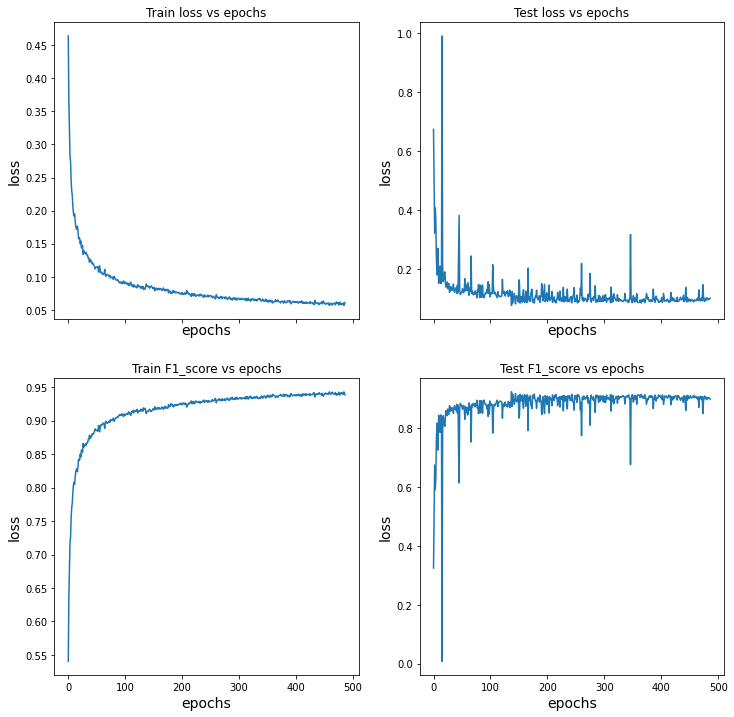

In [23]:
model_wrapper.draw_metrics()

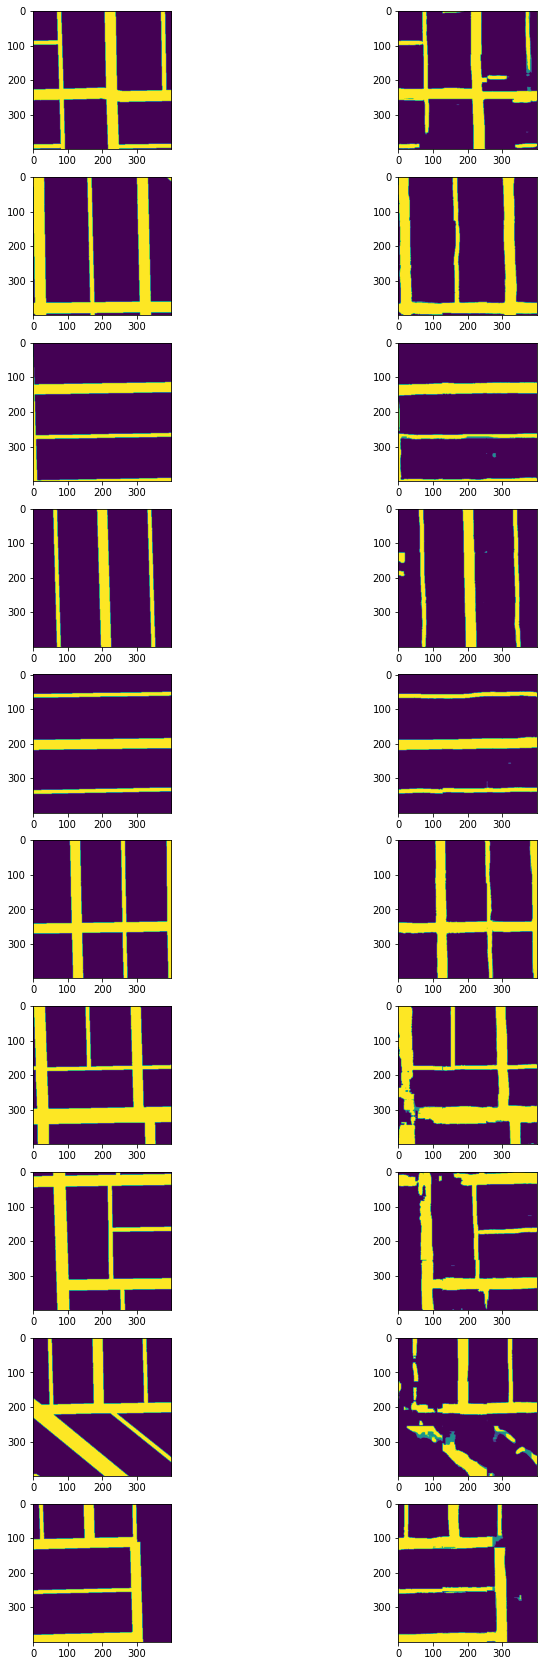

In [25]:
#predictions on test images
fig, ax = plt.subplots(10,2, figsize=(12, 30))
y_pred = model_wrapper.predict(x_test)
for i in range(10):
    ax[i,0].imshow(y_test[i,:,:,0])
    ax[i,1].imshow(y_pred[i,:,:,0])
plt.show()

In [53]:
def load_test_data():
    data = []
    for i in range(TEST_SAMPLES):
        img_name = '/test_{}/test_{}.png'.format(i+1, i+1)
        test_feature = plt.imread(TEST_FEATURES_PATH + img_name)
        data.append(test_feature)
    data = np.asarray(data)
    return data

test_data = load_test_data()

In [33]:
test_data.shape

(50, 608, 608, 3)

In [37]:
def predict(model, images, shift):
        
        image_side = images.shape[1]
        input_side = 128
        pred = np.zeros([images.shape[0], image_side, image_side, 1])
        #count number of predictions for each pixel
        counter = np.zeros([images.shape[0], image_side, image_side, 1])
        
        for x0 in range(0, image_side, shift):
            for y0 in range(0, image_side, shift):
                #prevent going out of borders
                x = min(x0, image_side - input_side)
                y = min(y0, image_side - input_side)
                pred[:, x:x+input_side, y:y+input_side, :] += model.predict(images[:, x:x+input_side, y:y+input_side, :])
                counter[:, x:x+input_side, y:y+input_side, :] += 1
        
        return pred / counter

In [38]:
preds = predict(model_wrapper.model, test_data, 16)
preds = np.round(preds)

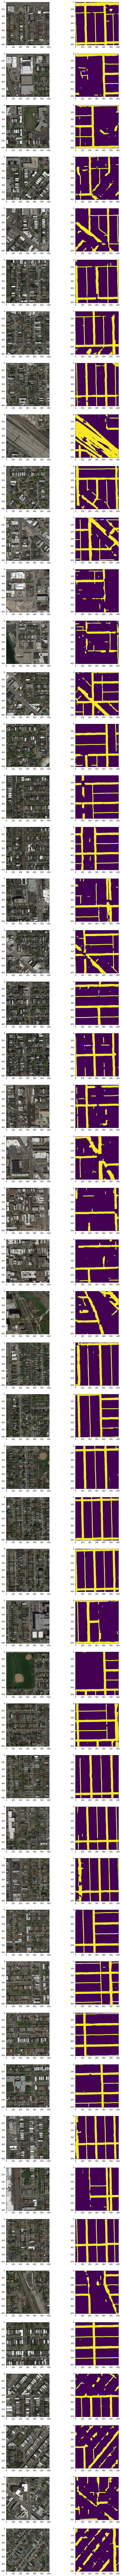

In [55]:
#predictions to be submitted
fig, ax = plt.subplots(50,2,figsize=(12, 250))
for i in range(50):
    ax[i,0].imshow(test_data[i])
    ax[i,1].imshow(preds[i,:,:,0])
plt.show()

In [49]:
def save_preds(preds):
    path = '/data/predictions'
    for i in range(len(preds)):
        img = Image.fromarray((preds[i,:,:,0] * 255.).astype(np.uint8))
        full_name = FILE_PATH + path + f'/pred_{i+1}.png'
        img.save(full_name)

save_preds(preds)